# 1. let's calculate the density of dry air

In [1]:
# ideal gas law (R: specific gas constant)
def rho(p, R, T):
    return p/(R*T)

In [2]:
import pint
si = pint.UnitRegistry()

In [3]:
from scipy import constants

R_str = constants.R * si.joule / si.kelvin / si.mole

In [4]:
import mendeleev as pt

def molar_mass(x):
    return x.atomic_weight * si.gram / si.mole

Md = (
    0.78 * molar_mass(pt.N) * 2 + 
    0.21 * molar_mass(pt.O) * 2 + 
    0.01 * molar_mass(pt.Ar)
)
print(f"Md = {Md}")

Md = 28.96998 gram / mole


In [5]:
rho_d = rho(
    p = 1000 * si.hectopascals,
    T = 300 * si.kelvins,
    R = R_str / Md
)
print(f"rho_d = {rho_d.to_base_units():.3g}")
print(f"rho_d = {rho_d.to(si.gram / si.centimetre**3):.3g}")

rho_d = 1.16 kilogram / meter ** 3
rho_d = 0.00116 gram / centimeter ** 3


# 2. let's get some real data

In [6]:
from datetime import datetime
from siphon.simplewebservice.wyoming import WyomingUpperAir

In [7]:
date = datetime(2020, 2, 23, 0)
station = '12425'

In [8]:
df = WyomingUpperAir.request_data(date, station)

In [9]:
print(df)

    pressure  height  temperature  dewpoint  direction  speed      u_wind  \
0     1001.0     116         10.8       2.8        260     10    9.848078   
1     1000.0     131         10.8       2.8        260     10    9.848078   
2      949.0     564          7.2       1.8        270     39   39.000000   
3      925.0     776          5.4       1.3        275     41   40.843983   
4      862.0    1347         -0.1      -0.1        279     46   45.433664   
5      850.0    1459         -0.7      -0.7        280     47   46.285964   
6      817.0    1772         -2.6      -2.6        285     52   50.228143   
7      740.0    2553         -7.3      -7.3        288     59   56.112334   
8      725.0    2714         -4.1      -7.6        289     60   56.731115   
9      700.0    2990         -4.9      -9.5        290     62   58.260942   
10     693.0    3069         -4.7     -10.7        292     63   58.412583   
11     681.0    3206         -5.8     -10.8        295     64   58.003698   

# 3. let's learn a bit more about water at saturation

In [10]:
# coefficients from Flatau et al. 1992
# doi:10.1175/1520-0450(1992)031<1507%3APFTSVP>2.0.CO%3B2

c_w = (
    6.115836990e000,
    0.444606896e000,
    0.143177157e-01,
    0.264224321e-03,
    0.299291081e-05,
    0.203154182e-07,
    0.702620698e-10,
    0.379534310e-13,
    -.321582393e-15
)

c_i = (
    6.098689930e000,
    0.499320233e000,
    0.184672631e-01,
    0.402737184e-03,
    0.565392987e-05,
    0.521693933e-07,
    0.307839583e-09,
    0.105785160e-11,
    0.161444444e-14
)

In [11]:
T0 = constants.zero_Celsius * si.kelvin
# triple point
p_tri = 611.73 * si.pascal
T_tri = 273.16 * si.kelvin

In [12]:
import numpy as np
from numpy.polynomial.polynomial import polyval

def __p_sat(temperature, coefficients, valid_range):
    value = polyval(temperature.to(si.celsius).magnitude, coefficients)

    if isinstance(temperature.magnitude, np.ndarray):
        value[np.logical_or(temperature < valid_range[0], temperature > valid_range[1])] = np.nan
    else:
        value = np.nan if not valid_range[0] < temperature <= valid_range[1] else value
        
    return value * si.hectopascals    

def p_vw(T):
    return __p_sat(T, c_w, (T0-85 * si.kelvin, np.inf * si.kelvin))

def p_vi(T):
    return __p_sat(T, c_i, (T0-90 * si.kelvin, T_tri))

In [13]:
assert abs(p_vw(T_tri) - p_tri) < 1 * si.pascal
assert abs(p_vi(T_tri) - p_tri) < 2 * si.pascal

In [14]:
from matplotlib import pyplot
si.setup_matplotlib()

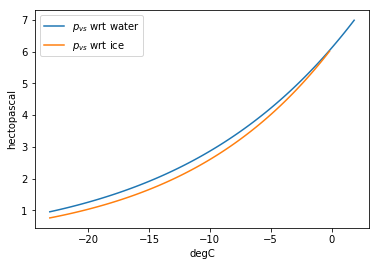

In [15]:
Tx = np.linspace(250, 275, 100) * si.kelvin
pyplot.plot(Tx, p_vw(Tx), label='$p_{vs}$ wrt water')
pyplot.plot(Tx, p_vi(Tx), label='$p_{vs}$ wrt ice')
pyplot.gca().xaxis.set_units(si.celsius) 
pyplot.gca().yaxis.set_units(si.hectopascal) 
pyplot.legend()

# 4. let's then plot the sounding data

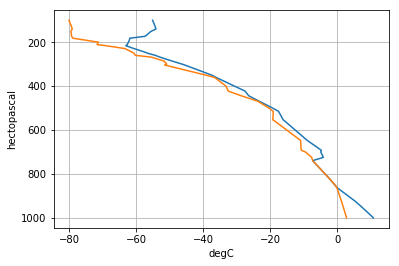

In [16]:
T = T0 + df.temperature.values * si.kelvin
Td = T0 + df.dewpoint.values * si.kelvin
p = df.pressure.values * si.hectopascal

pyplot.plot(T, p, label='T')
pyplot.plot(Td, p, label='$T_d$')
pyplot.gca().invert_yaxis()
pyplot.gca().xaxis.set_units(si.celsius)
pyplot.grid()

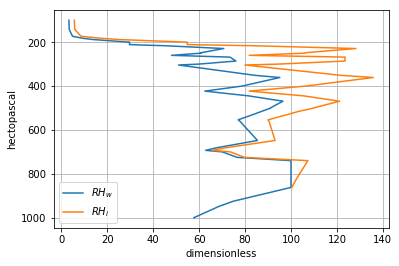

In [17]:
RH_w = 100 * p_vw(Td) / p_vw(T)
RH_i = 100 * p_vw(Td) / p_vi(T)

pyplot.plot(RH_w, p, label='$RH_w$')
pyplot.plot(RH_i, p, label='$RH_i$')
pyplot.gca().invert_yaxis()
pyplot.legend()
pyplot.grid()
pyplot.legend()

# 5. boiling point

In [18]:
from scipy.optimize import root_scalar

def T_boil(p):
    result = root_scalar(
        lambda x: (p - p_vw(x*si.kelvin)).magnitude, 
        x0=300, 
        x1=400
    )
    assert result.converged
    return result.root * si.kelvins

In [19]:
p = 500 * si.hectopascals
print(f"T_boil @ p={p} = {T_boil(p).to(si.celsius):.3g}")

T_boil @ p=500 hectopascal = 81.2 degC
